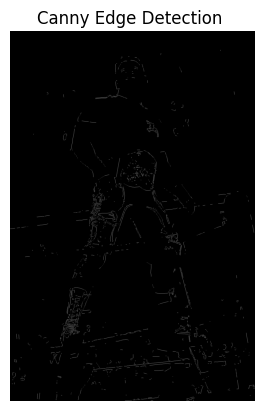

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.ndimage import convolve


def gaussian_kernel(size, sigma):
    kernel = np.fromfunction(
        lambda x, y: (1 / (2 * np.pi * sigma ** 2)) *
                     np.exp(- ((x - (size - 1) / 2) ** 2 + (y - (size - 1) / 2) ** 2) / (2 * sigma ** 2)),
        (size, size)
    )
    return kernel / np.sum(kernel)


def apply_gaussian_blur(image, kernel):
    return convolve(image, kernel)


def sobel_filters(image):
    sobel_x = np.array([[-1, 0, 1], [-2, 0, 2], [-1, 0, 1]])
    sobel_y = np.array([[-1, -2, -1], [0, 0, 0], [1, 2, 1]])

    gradient_x = convolve(image, sobel_x)
    gradient_y = convolve(image, sobel_y)

    return gradient_x, gradient_y


def compute_magnitude_direction(gradient_x, gradient_y):
    magnitude = np.sqrt(gradient_x**2 + gradient_y**2)
    direction = np.arctan2(gradient_y, gradient_x) * 180 / np.pi  # in degrees
    direction[direction < 0] += 180  # Adjust direction to [0, 180]
    return magnitude, direction


def non_maximum_suppression(magnitude, direction):
    rows, cols = magnitude.shape
    suppressed_image = np.zeros_like(magnitude)

    for i in range(1, rows - 1):
        for j in range(1, cols - 1):
            angle = direction[i, j]

            if (0 <= angle < 22.5) or (157.5 <= angle < 180):
                neighbor1, neighbor2 = magnitude[i, j - 1], magnitude[i, j + 1]
            elif (22.5 <= angle < 67.5):
                neighbor1, neighbor2 = magnitude[i - 1, j + 1], magnitude[i + 1, j - 1]
            elif (67.5 <= angle < 112.5):
                neighbor1, neighbor2 = magnitude[i - 1, j], magnitude[i + 1, j]
            elif (112.5 <= angle < 157.5):
                neighbor1, neighbor2 = magnitude[i - 1, j - 1], magnitude[i + 1, j + 1]

            if magnitude[i, j] >= max(neighbor1, neighbor2):
                suppressed_image[i, j] = magnitude[i, j]
            else:
                suppressed_image[i, j] = 0

    return suppressed_image


def double_thresholding(suppressed_image, low_threshold, high_threshold):
    strong_edges = suppressed_image > high_threshold
    weak_edges = (suppressed_image >= low_threshold) & (suppressed_image <= high_threshold)
    return strong_edges, weak_edges


def edge_tracking(strong_edges, weak_edges):
    rows, cols = strong_edges.shape
    final_edges = np.zeros_like(strong_edges, dtype=np.uint8)

    for i in range(1, rows - 1):
        for j in range(1, cols - 1):
            if strong_edges[i, j]:
                final_edges[i, j] = 255
            elif weak_edges[i, j]:
                if np.any(strong_edges[i-1:i+2, j-1:j+2]):
                    final_edges[i, j] = 255

    return final_edges


def canny_edge_detection(image, low_threshold=50, high_threshold=150, gaussian_size=5, sigma=1.4):
    kernel = gaussian_kernel(gaussian_size, sigma)
    blurred_image = apply_gaussian_blur(image, kernel)

    gradient_x, gradient_y = sobel_filters(blurred_image)

    magnitude, direction = compute_magnitude_direction(gradient_x, gradient_y)

    suppressed_image = non_maximum_suppression(magnitude, direction)

    strong_edges, weak_edges = double_thresholding(suppressed_image, low_threshold, high_threshold)

    final_edges = edge_tracking(strong_edges, weak_edges)

    return final_edges


image_path = r'D:\AIDS_PR_EXAM\Computer Vision\ReyMysterio.jpg'
image = plt.imread(r'D:\AIDS_PR_EXAM\Computer Vision\EddieG.jpg')

if len(image.shape) == 3:
    image = np.dot(image[:, :, :3], [0.2989, 0.5870, 0.1140])

edges = canny_edge_detection(image)

plt.imshow(edges, cmap='gray')
plt.title('Canny Edge Detection ')
plt.axis('off')
plt.show()


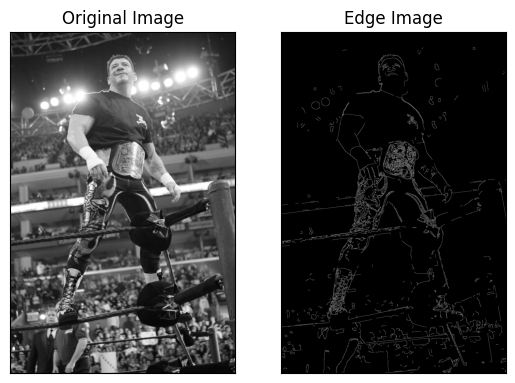

In [3]:
import numpy as np
import cv2 as cv
from matplotlib import pyplot as plt

img = cv.imread(r'D:\AIDS_PR_EXAM\Computer Vision\EddieG.jpg', cv.IMREAD_GRAYSCALE)
assert img is not None, "file could not be read, check with os.path.exists()"
edges = cv.Canny(img,100,200)

plt.subplot(121),plt.imshow(img,cmap = 'gray')
plt.title('Original Image'), plt.xticks([]), plt.yticks([])
plt.subplot(122),plt.imshow(edges,cmap = 'gray')
plt.title('Edge Image'), plt.xticks([]), plt.yticks([])

plt.show()

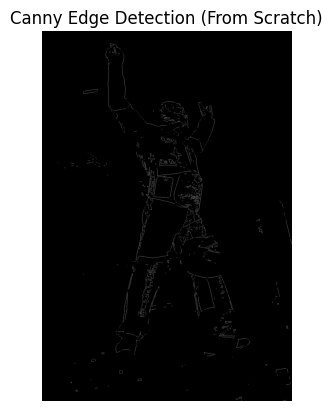

In [5]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.ndimage import convolve


# Step 1: Gaussian Blur
def gaussian_kernel(size, sigma):
    kernel = np.fromfunction(
        lambda x, y: (1 / (2 * np.pi * sigma ** 2)) *
                     np.exp(- ((x - (size - 1) / 2) ** 2 + (y - (size - 1) / 2) ** 2) / (2 * sigma ** 2)),
        (size, size)
    )
    return kernel / np.sum(kernel)


def apply_gaussian_blur(image, kernel):
    return convolve(image, kernel)


# Step 2: Sobel Filter (Gradient Calculation)
def sobel_filters(image):
    sobel_x = np.array([[-1, 0, 1], [-2, 0, 2], [-1, 0, 1]])
    sobel_y = np.array([[-1, -2, -1], [0, 0, 0], [1, 2, 1]])

    gradient_x = convolve(image, sobel_x)
    gradient_y = convolve(image, sobel_y)

    return gradient_x, gradient_y


# Step 3: Compute Gradient Magnitude and Direction
def compute_magnitude_direction(gradient_x, gradient_y):
    magnitude = np.sqrt(gradient_x**2 + gradient_y**2)
    direction = np.arctan2(gradient_y, gradient_x) * 180 / np.pi  # in degrees
    direction[direction < 0] += 180  # Adjust direction to [0, 180]
    return magnitude, direction


# Step 4: Non-Maximum Suppression
def non_maximum_suppression(magnitude, direction):
    rows, cols = magnitude.shape
    suppressed_image = np.zeros_like(magnitude)

    for i in range(1, rows - 1):
        for j in range(1, cols - 1):
            angle = direction[i, j]

            # Check direction and compare pixel values along the gradient direction
            if (0 <= angle < 22.5) or (157.5 <= angle < 180):
                neighbor1, neighbor2 = magnitude[i, j - 1], magnitude[i, j + 1]
            elif (22.5 <= angle < 67.5):
                neighbor1, neighbor2 = magnitude[i - 1, j + 1], magnitude[i + 1, j - 1]
            elif (67.5 <= angle < 112.5):
                neighbor1, neighbor2 = magnitude[i - 1, j], magnitude[i + 1, j]
            elif (112.5 <= angle < 157.5):
                neighbor1, neighbor2 = magnitude[i - 1, j - 1], magnitude[i + 1, j + 1]

            if magnitude[i, j] >= max(neighbor1, neighbor2):
                suppressed_image[i, j] = magnitude[i, j]
            else:
                suppressed_image[i, j] = 0

    return suppressed_image


# Step 5: Double Thresholding
def double_thresholding(suppressed_image, low_threshold, high_threshold):
    strong_edges = suppressed_image > high_threshold
    weak_edges = (suppressed_image >= low_threshold) & (suppressed_image <= high_threshold)
    return strong_edges, weak_edges


# Step 6: Edge Tracking by Hysteresis
def edge_tracking(strong_edges, weak_edges):
    rows, cols = strong_edges.shape
    final_edges = np.zeros_like(strong_edges, dtype=np.uint8)

    for i in range(1, rows - 1):
        for j in range(1, cols - 1):
            if strong_edges[i, j]:
                final_edges[i, j] = 255
            elif weak_edges[i, j]:
                if np.any(strong_edges[i-1:i+2, j-1:j+2]):  # Check 8 neighbors
                    final_edges[i, j] = 255

    return final_edges


# Main Canny Edge Detection Function
def canny_edge_detection(image, low_threshold=50, high_threshold=150, gaussian_size=5, sigma=1.4):
    # Step 1: Gaussian Blurring
    kernel = gaussian_kernel(gaussian_size, sigma)
    blurred_image = apply_gaussian_blur(image, kernel)

    # Step 2: Sobel Filters for Gradient Calculation
    gradient_x, gradient_y = sobel_filters(blurred_image)

    # Step 3: Compute Gradient Magnitude and Direction
    magnitude, direction = compute_magnitude_direction(gradient_x, gradient_y)

    # Step 4: Non-Maximum Suppression
    suppressed_image = non_maximum_suppression(magnitude, direction)

    # Step 5: Double Thresholding
    strong_edges, weak_edges = double_thresholding(suppressed_image, low_threshold, high_threshold)

    # Step 6: Edge Tracking by Hysteresis
    final_edges = edge_tracking(strong_edges, weak_edges)

    return final_edges


# Load an image and convert it to grayscale (replace 'image_path.jpg' with your image file)
image_path = r'D:\AIDS_PR_EXAM\Computer Vision\ReyMysterio.jpg'  # Replace with your image path
image = plt.imread(image_path)

# If the image is in RGB, convert to grayscale
if len(image.shape) == 3:
    image = np.dot(image[:, :, :3], [0.2989, 0.5870, 0.1140])

# Perform Canny Edge Detection
edges = canny_edge_detection(image)

# Display the result
plt.imshow(edges, cmap='gray')
plt.title('Canny Edge Detection (From Scratch)')
plt.axis('off')
plt.show()
